In [1]:
import orbit_classes as orb
import numpy as np
import glob
from astropy.io import ascii as a
from astropy.time import Time
import matplotlib.pyplot as plt
#import h5py
import hci_util as util
import astropy.constants as const

from importlib import reload

In [2]:
reload(orb)

<module 'orbit_classes' from '/Users/annaboehle/research/code/orbits/orbit_classes.py'>

In [3]:
star = orb.Star('40_eri',4.98,(2.8,5.6,8.4),{'Lp':2.370},0.67,teff=2000,radius=1.0)  # random teff and r

Set up simulation

In [4]:
del_a = 2.
a_arr = np.arange(del_a/2., 2.0*star.dist*4.0,del_a) 

del_m_p = 3.
m_p_arr = np.arange(del_m_p/2., 50, del_m_p) 

### RV data set

In [5]:
def get_rv_timeseries(star):
    rvDir = '/Users/annaboehle/research/analysis/archival_stars/rv_calibrated'

    file_ls = glob.glob('{:s}/{:s}/{:s}*cal.dat'.format(rvDir, star, star))
    rv_epochs = []
    rv_meas = []
    for f in file_ls:
        rv_tab = a.read(f,names=('rjd','vrad'))
        # rv_epochs.append(ascii.read(f))
        rv_epochs.extend(rv_tab['rjd'][:])
        rv_meas.extend(rv_tab['vrad'][:])

    return np.array(rv_epochs, dtype=float) + 2400000, np.array(rv_meas)

In [6]:
t, rv_meas=get_rv_timeseries('40_eri')
rv_dataset = orb.RVDataSet(t, rv_meas,star)

In [7]:
sim = orb.CompletenessMC(a_arr,1000,[rv_dataset],mp_arr=m_p_arr)

In [8]:
out=sim.run()

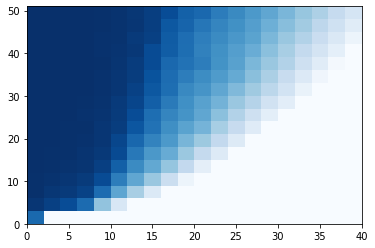

In [9]:
extent=[0,a_arr[-1]+del_a*0.5,0,m_p_arr[-1]+del_m_p*0.5]

plt.imshow(out[0]*100.,origin='lower',cmap='Blues', 
           extent=extent,aspect='auto',vmin=0,vmax=100)  

### HCI data set

In [26]:
star_name = '40_eri'

In [27]:
t_hci = Time('2008-11-16')
print(t_hci.decimalyear)

2008.8743169398906


In [28]:
sep = np.array([0.345, 0.445, 0.545, 0.645, 0.745, 0.845, 0.945, 1.045, 1.145,
       1.245, 1.345, 1.445, 1.545, 1.645, 1.745, 1.845, 1.945])
contrast = np.array([ 5.89398451, 11.13199795, 12.00855101, 12.57479667, 13.07858451,
       12.83411251, 13.42493691, 13.52553135, 13.56641038, 13.78909367,
       13.7870043 , 13.68065617, 13.70834146, 13.83224703, 13.74749432,
       13.73895328, 13.70722755])
print(len(contrast),len(sep))

17 17


In [29]:
reload(orb)
hci_dataset = orb.ImagingDataSet(t_hci.decimalyear,
                               contrast,
                               star,
                               "L'",
                                sep=sep)

In [31]:
model = orb.ContrastModel('phoenix')

In [35]:
sim = orb.CompletenessMC(a_arr,1000,[hci_dataset],model=model,mp_arr=m_p_arr)

In [ ]:
out=sim.run()  # I think this doesn't work bc of the segmentation fault issue with griddata

## Compare with and without planet mass in p <-> a conversions

In [10]:
planet = orb.Planet(1)

In [11]:
nsamples = 10
e, o, t0 = 0., 0., 0.  # self.o needs to be sampled for 2d contrast map

unif = np.random.uniform(size=nsamples)
i = np.arccos(unif) * (180. / np.pi)

w = np.random.uniform(size=nsamples, low=0, high=360.)

a = 1

In [13]:
reload(orb)

p1 = np.sqrt(a ** 3. / (star.mass)) * 365.

orbit_set_nomp = orb.Orbit(e,
                  p1,
                  t0,
                  i,
                  w,
                  o,
                  star,
                  planet)

out_nomp = orbit_set_nomp.get_orbit_solution(np.linspace(0,p1,1000),exact_total_mass=False)

In [15]:
reload(orb)

p2 = np.sqrt(a ** 3. / (star.mass + planet.mass * 954.7919e-6)) * 365.

print(p1-p2)

orbit_set_wmp = orb.Orbit(e,
                  p2,
                  t0,
                  i,
                  w,
                  o,
                  star,
                  planet)

out_wmp = orbit_set_nomp.get_orbit_solution(np.linspace(0,p1,1000),exact_total_mass=True)

0.317391667525726


(-24.75, 24.75, -24.75, 24.75)

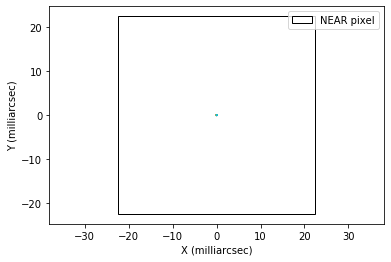

In [16]:
plt.plot((out_wmp[0]-out_nomp[0])*1e3,(out_wmp[1]-out_nomp[1])*1e3)
if True:
    r = plt.Rectangle((-45./2,-45./2),45,45,fill=False,label='NEAR pixel')
    plt.gca().add_patch(r)
    plt.legend()
    
plt.xlabel('X (milliarcsec)')
plt.ylabel('Y (milliarcsec)')
plt.axis('equal')

### Test mass-radius relationship

In [17]:
reload(util)
reload(orb)

<module 'orbit_classes' from '/Users/annaboehle/research/code/orbits/orbit_classes.py'>

In [20]:
p1 = orb.Planet(mass=1.0)
print(p1.radius)
print()

p2 = orb.Planet(radius=p1.radius)
print(p2.mass)
print()

p3 = orb.Planet(radius=100)
print(p3.mass)

12.214426501982073

0.999999999999997

5.222944096740198


891.5321412121012


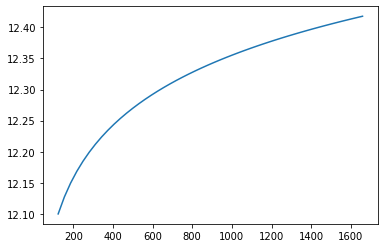

In [21]:
masses = np.linspace(124,5.22*const.M_jup/const.M_earth)
rads = util.mass_radius_relationship(masses)
plt.plot(masses,rads)
print(np.average(masses))

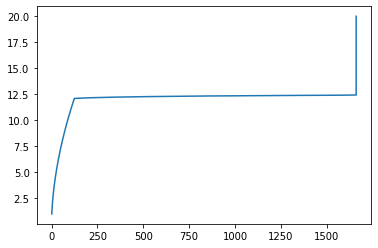

In [22]:
rads = np.linspace(1.0,20,1000)
masses = util.radius_mass_relationship(rads)
plt.plot(masses,rads)

## Test sim with rp_arr input

In [23]:
sim = orb.CompletenessMC(a_arr,1000,[rv_dataset],mp_arr=m_p_arr)
print([p.mass for p in sim.p_ls])
print(m_p_arr)
print()
print([p.radius for p in sim.p_ls])

[1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 22.5, 25.5, 28.5, 31.5, 34.5, 37.5, 40.5, 43.5, 46.5, 49.5]
[ 1.5  4.5  7.5 10.5 13.5 16.5 19.5 22.5 25.5 28.5 31.5 34.5 37.5 40.5
 43.5 46.5 49.5]

[12.264052279220689, 12.39952948665897, 12.463031514732158, 12.505036784025418, 12.536503269072425, 12.561685615713667, 12.582687962391981, 12.600706784487164, 12.61648809926761, 12.630528675197018, 12.643176073050073, 12.654683028392771, 12.665239107010484, 12.67499015866376, 12.684050812255016, 12.69251280147864, 12.700450686930624]


In [24]:
sim = orb.CompletenessMC(a_arr,1000,[rv_dataset],rp_arr=np.linspace(1,10,10))

print([p.radius for p in sim.p_ls])
print(np.linspace(1,10,10))
print()
print([p.mass for p in sim.p_ls])

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

[0.0041930332013344895, 0.014786165608817825, 0.030904483637710454, 0.052141417182626854, 0.07823171565099907, 0.10898049006069263, 0.14423484500743017, 0.18386966964521245, 0.22777952452404715, 0.27587358552502456]
